# 增加商品單元數量是有效的促銷手段
## 摘要  
以男士洗面奶市場為例,評估商品單元數量與銷售量的關係，推斷增加商品單元數量是否有效的促銷策略。

In [1]:
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

## 數據描述

data為淘寶以"男士洗面奶"為關鍵字的爬取結果(2023年11月的銷售情況)  
每條數據為一個商品單元(對其數量簡稱"單元量")。  

在本研究中，我們採用了手工標記品牌和簡化的數據處理方法（如將銷量 3000+ 按 3000 處理）,并僅對銷量前50%的數據進行採樣。  
雖然這些方法能夠滿足需求，但可能對銷量估計產生一定偏差，進而影響結論的嚴謹性。  

結果而言, 偏差不妨礙評估    單元量與銷售量    的關係。  

    title = 商品標題  
    price = 定價  
    sales = 銷售量  
    rank = 按銷售排名  
    brand = 品牌名稱  

In [2]:
data =  pd.read_csv('data.csv')
data.head(10)

,title,price,sales,rank,brand
0,左颜右色微酸洗面奶男士专用氨基酸洁面乳控油祛痘去黑头护肤品套,59,30000,9,左颜右色
1,左颜右色益生菌洗面奶男士氨基酸洁面乳驱螨控油清洁祛净痘护肤品,69,1000,294,左颜右色
2,自然堂男士喜马拉雅龙血控油醒肤洁面乳清洁控油清爽洁面,48,1000,294,自然堂
3,日本资生堂洗面奶女珊珂洗颜专科洁面乳男清洁控油补水保湿旗舰店,42,10000,19,资生堂
4,资生堂uno洗面奶男士专用控油祛痘补水保湿去黑头洁面乳吾诺正品,17,10000,19,资生堂
5,资生堂uno洗面奶男士专用祛痘控油女深层清洁去黑头吾诺洁面正品,15,5000,103,资生堂
6,资生堂男士洗面奶洁面乳膏清爽控油洁净补水125ml,200,4000,132,资生堂
7,日本资生堂uno吾诺男士专用深层清洁控油保湿洗面奶去黑头旗舰店,17,4000,132,资生堂
8,【自营】资生堂男士洗面奶125ml洁面保湿不紧绷控油补水正品男生,125,3000,165,资生堂
9,资生堂uno洗面奶男士专用控油祛痘去黑头洁面乳秋冬官方正品旗舰,38,3000,165,资生堂


In [3]:
# 按品牌分組聚合數據，並按銷售量排序
query = """
SELECT
    brand,
    COUNT(title) AS Frequency,
    SUM(sales) AS sales_volume
FROM
    data
GROUP BY
    brand
ORDER BY
    sales_volume DESC

"""
# 執行查詢
brand_description = ps.sqldf(query, locals())
brand_description

,brand,Frequency,sales_volume
0,欧莱雅,26,156000
1,溪木源,7,148000
2,半亩花田,9,114000
3,freeplus芙丽芳丝,8,110000
4,德妃,6,79000
...,...,...,...
138,gnmn,1,1000
139,eitiko,1,1000
140,drogistplein,1,1000
141,broda博乐达,1,1000


## 統計每個品牌在淘寶上所佔有的單元量和總銷量(僅淘寶)
    Frequency = 某品牌在該電商平台上以"男士洗面奶"為關鍵字，能夠找到的單元量  
    sales_volume = 所有單元銷量之和  

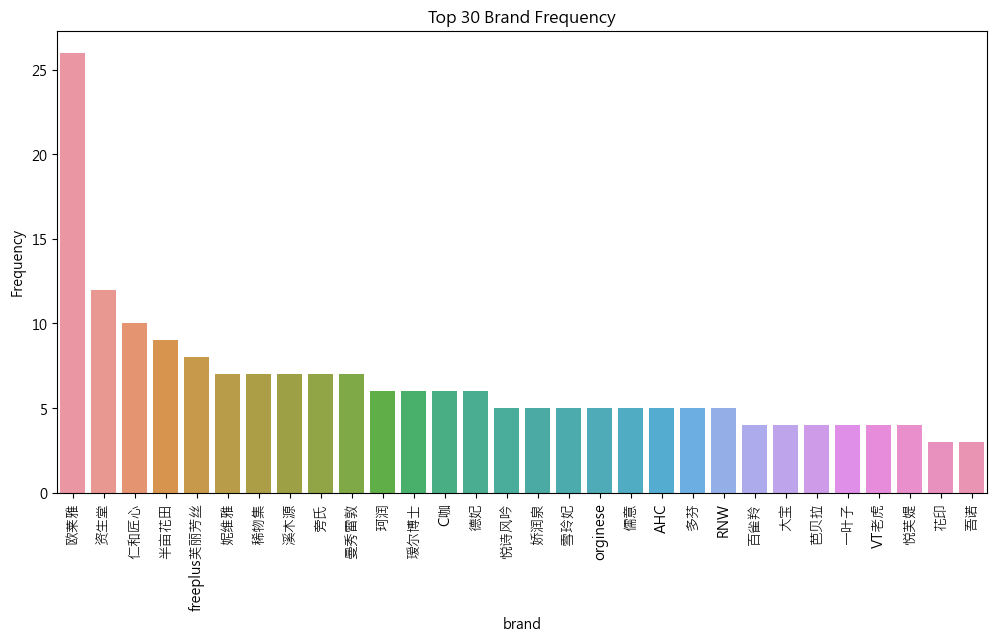

In [4]:
# 柱狀圖,由高到低排序,顯示前10名Frequency
plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='Frequency', data=brand_description.sort_values('Frequency', ascending=False).head(30))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']# 中文字體
plt.xticks(rotation=90)# X軸標題施加90度旋轉
plt.title('Top 30 Brand Frequency')
plt.show()

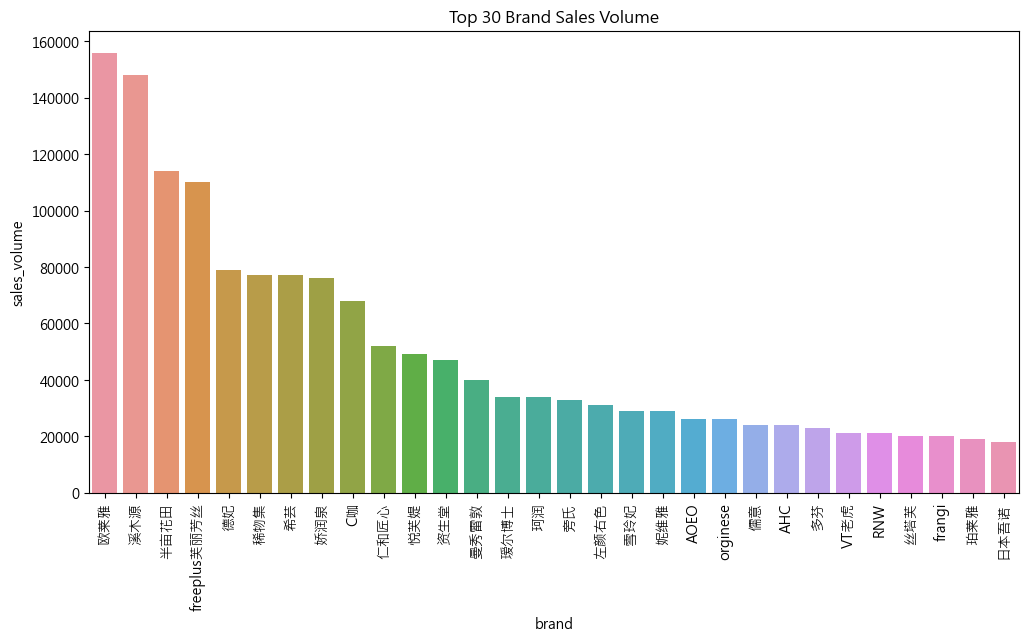

In [5]:
# 柱狀圖,由高到低排序,顯示前10名sales_volume
plt.figure(figsize=(12, 6))
sns.barplot(x='brand', y='sales_volume', data=brand_description.sort_values('sales_volume', ascending=False).head(30))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']# 中文字體
plt.xticks(rotation=90)# X軸標題施加90度旋轉
plt.title('Top 30 Brand Sales Volume')
plt.show()

## 以一元線性回歸分析,單元量和總銷量之間的關係
由於圖表上單元量和總銷量程現出類似幂律分佈的特徵，我們將進行對數變換處理。

單元量每增長2倍，總銷量對應增長2.89倍


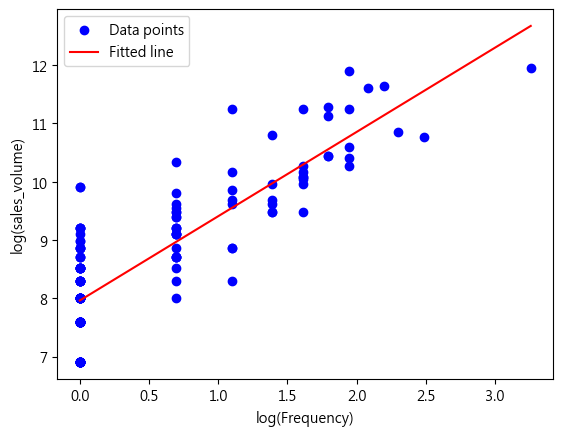

In [6]:
# 用線性回歸模型分析Frequency和sales_volume之間的關係
X = np.array(brand_description['Frequency']).reshape(-1, 1)
Y = np.array(brand_description['sales_volume'])
log_X = np.log(X)
log_Y = np.log(Y)

# 創建線性回歸模型
model = LinearRegression()

# 擬合模型
model.fit(log_X, log_Y)

# 输出模型参数
slope = model.coef_[0]

print(f'單元量每增長2倍，總銷量對應增長{slope*2:.2F}倍')

# 預測
Y_pred = model.predict(log_X)

# 繪圖
plt.scatter(log_X,log_Y, color='blue', label='Data points')
plt.plot(log_X, Y_pred, color='red', label='Fitted line')
plt.xlabel('log(Frequency)')
plt.ylabel('log(sales_volume)')
plt.legend()
plt.show()

In [7]:
# 計算皮爾森相關係數
corr, _ = pearsonr(np.log(brand_description['Frequency']), log_Y)

# 判斷相關性
if corr > 0.6:
    print(f"X和Y之間的相關性強，相關係數為{corr:.2f}") 
else:
    print(f"X和Y之間的相關性弱，相關係數為{corr:.2f}")

X和Y之間的相關性強，相關係數為0.84


## 小結:單元量和總銷量的增長率互為幂次關係
通過對數變換後進行線性回歸，證明單元量和總銷量 的增長率存在幂次關係。  
經計算，對數變換後的皮爾遜相關係數為 0.8，表明兩者之間存在較強的正相關性，進一步支持其幂次關係假設。

由於銷量數據中有些值被簡化（如3000+ = 3000），這可能會造成單元量較低水平的銷量跨度較大。  
然而，這種簡化對回歸模型和皮爾遜相關係數計算的影響較小，因此不會顯著影響結果的可靠性。  

由於僅對銷量前50%的數據進行採樣，這可能會導致單元量為1的品牌銷量估計偏高。  
然而，這樣的偏差並不會推翻結果，反而更強烈支持了單元量和總銷量之間的正向關聯。

# 推斷:上架更多的商品單元是有效的促銷策略
從圖表及計算出的皮爾森相關係數來看，單元量的對數與該品牌總銷量的對數之間存在較強的相關性。  
雖然相關性並不等同於因果關係，但考慮到推薦算法的隨機性和商品爆品效應的可能性，上架更多商品單元是一個合理的促銷策略。  

相比於對少數商品單元進行深入優化，‘廣撒網’策略可能更有效，因為隨著單元量的增加，爆品出現的概率也會提升。  
此外，商品單元每增加一倍，其平均成本可能因規模經濟效應而邊際遞減；  
而銷量每增加一倍，其平均利潤可能因規模效益而邊際遞增，進一步支持了該策略的經濟可行性。  
  
   
By PuiSan_L  